In [1]:
import os
from os import path
import sys
import math
import cv2 # Read raw image
import glob
import random
import numpy as np
import pickle
from matplotlib import pyplot as plt
from scipy import ndimage # For rotation task or
import imutils
from skimage.color import rgb2lab, lab2rgb, rgb2gray
from skimage.io import imsave
from skimage.transform import resize
from pprint import pprint

import tensorflow
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.python.keras.utils import data_utils
from tensorflow.keras.preprocessing.image import Iterator
from tensorflow.keras import Input
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, UpSampling2D, AveragePooling2D, MaxPooling2D, Reshape, Conv2DTranspose, ZeroPadding2D, Add
from tensorflow.keras.layers import Activation, InputLayer, BatchNormalization
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras.layers import PReLU


# Check to see if GPU is being used
print(tensorflow.test.gpu_device_name())
print("Num GPUs Available: ", tf.config.experimental.list_physical_devices('GPU'))
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

/device:GPU:0
Num GPUs Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]
Num GPUs Available:  2


In [2]:
"""
Parameters:
1. Data path
2. Normalize or not
3. Tensorboard Log Directory
4. Model path to save
"""
DATA_PATH = "/home/satyarth934/data/modis_data_products/*/array_3bands_normalized/448/*"
# DATA_PATH = "/home/satyarth934/data/modis_data_products/terra/array_3bands_adapted/448/mean_stdev_removed/*" # <- needs to be normalized
# DATA_PATH = "/home/satyarth934/data/modis_data_products/terra/array_3bands_adapted/448/median_removed/*" # <- needs to be normalized
NORMALIZE = True

MODEL_NAME = "baseAE_orig"
BASE_DIR = "/home/satyarth934/code/FDL_2020/"

OUTPUT_MODEL_PATH = BASE_DIR + "Models/" + MODEL_NAME
TENSORBOARD_LOG_DIR = BASE_DIR + "tb_logs/" + MODEL_NAME
ACTIVATION_IMG_PATH = BASE_DIR + "activation_viz/" + MODEL_NAME
PATH_LIST_LOCATION = BASE_DIR + "activation_viz/" + MODEL_NAME + "/train_test_paths.npy"

NUM_EPOCHS = 200


In [3]:
def normalize(mat):
    normalized = (mat - np.nanmin(mat)) / (np.nanmax(mat) - np.nanmin(mat))
    return normalized


def getMedian():
    median_r_path = "/home/satyarth934/data/modis_data_products/terra/448_band_1_median.npy"
    median_g_path = "/home/satyarth934/data/modis_data_products/terra/448_band_4_median.npy"
    median_b_path = "/home/satyarth934/data/modis_data_products/terra/448_band_3_median.npy"

    median_r = np.load(median_r_path)
    median_g = np.load(median_g_path)
    median_b = np.load(median_b_path)

    median = np.dstack([median_r, median_g, median_b])
    
    return median

len(img_paths): 729
X_train: (583, 448, 448, 3)
X_test: (146, 448, 448, 3)
NaNs in Test and Train
0.10476336560031388
0.1116907071582914
Before normalization
0.0 1.0
0.0 1.0
After normalization
0.0 1.0
0.0 1.0


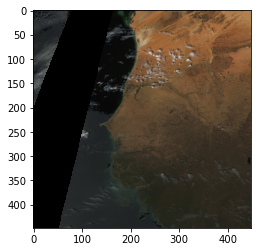

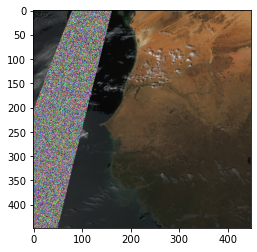

In [4]:
img_paths = glob.glob(DATA_PATH)
print("len(img_paths):", len(img_paths))
# random.shuffle(img_paths)

train_test_split = 0.8
X_train_paths = img_paths[:int(train_test_split * len(img_paths))]
X_test_paths = img_paths[int(train_test_split * len(img_paths)):]

dims = (448, 448, 3)

# Loading Training Data
X_train = np.empty((len(X_train_paths), *dims))
for i, p in enumerate(X_train_paths):
    X_train[i, :, :, :] = np.load(p)

# Loading Testing Data
X_test = np.empty((len(X_test_paths), *dims))
for i, p in enumerate(X_test_paths):
    X_test[i, :, :, :] = np.load(p)

print("X_train:", X_train.shape)
print("X_test:", X_test.shape)

# To check what percentage of pixels are 'nan'
print("NaNs in Test and Train")
print(np.sum(np.isnan(X_train)) / np.prod(X_train.shape))
print(np.sum(np.isnan(X_test)) / np.prod(X_test.shape))

# Checking min max to see if normalization is needed or not
print("Before normalization")
print(np.nanmin(X_train), np.nanmax(X_train))
print(np.nanmin(X_test), np.nanmax(X_test))

# Normalize Inputs
X_train = normalize(X_train)
X_test = normalize(X_test)

# Checking min max after normalization
print("After normalization")
print(np.nanmin(X_train), np.nanmax(X_train))
print(np.nanmin(X_test), np.nanmax(X_test))

plt.figure(1)
plt.imshow(X_train[15])
plt.show()
# median_img = getMedian()
# # X_train[np.isnan(X_train)] = median_img[np.isnan(X_train)]

# for i in range(len(X_train)):
#     X_train[i,:,:,:][np.isnan(X_train[i,:,:,:])] = median_img[np.isnan(X_train[i,:,:,:])]

# Set nan values to random
X_train[np.isnan(X_train)] = np.random.random(np.sum(np.isnan(X_train)))
X_test[np.isnan(X_test)] = np.random.random(np.sum(np.isnan(X_test)))


plt.figure(2)
plt.imshow(X_train[15])
plt.show()

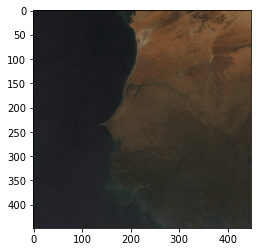